In [2]:
import torch
import numpy as np
from transformers import BertTokenizer, BertForMaskedLM

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()  # Set to evaluation mode

/Users/lzhao/miniconda3/envs/tsi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [24]:
# Input sentence with masks
import pandas as pd

df = pd.read_csv('masked_lm1b_sentences.csv', nrows=1, header=None)
sentence = df[0][0]
print(f"Input sentence: {sentence}")

# Tokenize and find mask positions
input_ids = tokenizer.encode(sentence, return_tensors='pt')
mask_positions = [i for i, token in enumerate(input_ids[0]) if token == tokenizer.mask_token_id]
m = len(mask_positions)  # Number of masked positions
N = tokenizer.vocab_size  
print(f"Number of masks: {m}, Vocabulary size: {N}")

# Get logits for masked positions
with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits  # Shape: (1, sequence_length, vocab_size)
logits_masked = [logits[0, pos, :] for pos in mask_positions]  # Logits for each mask

# Sampling parameters
n_steps = 100  # Number of sampling steps
use_dmala = True  # Toggle between DULA (False) and DMALA (True)
alpha = 0.15 if use_dmala else 0.1 # Step size, as used in the paper

# Initialize theta with the most likely words (argmax of logits)
theta = [torch.argmax(logits_masked[i]).item() for i in range(m)]
print(f"Initial theta (word indices): {theta}")
initial_words = [tokenizer.decode([k]) for k in theta]
print(f"Initial words: {initial_words}")

# Compute energy function U(theta)
def compute_U(theta, logits_masked):
    """
    Compute U(theta) = sum_i log p(theta_i | X_MASK[i])
    Args:
        theta: List of word indices for masked positions
        logits_masked: List of logit tensors for each masked position
    Returns:
        Energy value (scalar)
    """
    log_probs = sum(torch.log_softmax(logits_masked[i], dim=0)[theta[i]] for i in range(m))
    return log_probs.item()

# Compute proposal distribution q_i(theta_i' | theta)
def compute_proposal(i, theta, logits_masked, alpha):
    """
    Compute q_i(theta_i' | theta) for position i
    Args:
        i: Index of the masked position
        theta: Current state (list of word indices)
        logits_masked: List of logit tensors
        alpha: Step size
    Returns:
        torch.Tensor of probabilities over vocabulary
    """
    k = theta[i]  # Current word index at position i
    scores = torch.full((N,), float('-inf'))  # Initialize scores
    scores[k] = 0  # Score for staying at current state
    # For all other k' != k
    mask = torch.ones(N, dtype=bool)
    mask[k] = False
    scores[mask] = 0.5 * (logits_masked[i][mask] - logits_masked[i][k]) - 1 / alpha
    return torch.softmax(scores, dim=0)

# Sampling loop
samples = []
for step in range(n_steps):
    # Propose new state theta'
    theta_prime = []
    log_q_forward = 0  # log q(theta' | theta)
    for i in range(m):
        probs = compute_proposal(i, theta, logits_masked, alpha)
        k_prime = torch.multinomial(probs, 1).item()  # Sample new word index
        theta_prime.append(k_prime)
        log_q_forward += torch.log(probs[k_prime] + 1e-10).item()  # Add small epsilon to avoid log(0)

    # Compute energies
    U_theta = compute_U(theta, logits_masked)
    U_theta_prime = compute_U(theta_prime, logits_masked)

    if use_dmala:
        # Metropolis-Hastings step
        log_q_backward = 0  # log q(theta | theta')
        for i in range(m):
            probs_back = compute_proposal(i, theta_prime, logits_masked, alpha)
            log_q_backward += torch.log(probs_back[theta[i]] + 1e-10).item()

        # Acceptance probability
        log_accept = U_theta_prime - U_theta + log_q_backward - log_q_forward
        accept_prob = min(1, np.exp(log_accept))
        if np.random.rand() < accept_prob:
            theta = theta_prime
    else:
        # DULA: Always accept the proposal
        theta = theta_prime

    # Store sample
    if step % 5 == 0 or step == n_steps - 1:  # Save every 10 steps and the last one
        samples.append(theta.copy())

# Decode and display results
print(f"\nSampling method: {'DMALA' if use_dmala else 'DULA'}")
print(f"Number of steps: {n_steps}, Step size: {alpha}")
print("\nSampled sequences:")
for idx, theta_sample in enumerate(samples):
    words = [tokenizer.decode([k]) for k in theta_sample]
    print(f"Step {(idx * 5 if idx < len(samples) - 1 else n_steps - 1)}: {words}")

# Final sampled words
final_words = [tokenizer.decode([k]) for k in theta]
print(f"\nFinal sampled words: {final_words}")

# Reconstruct the sentence
tokens = input_ids[0].tolist()
for pos, word_idx in zip(mask_positions, theta):
    tokens[pos] = word_idx
final_sentence = tokenizer.decode(tokens, skip_special_tokens=True)
print(f"Final sentence: {final_sentence}")


Input sentence: [MASK] medieval [MASK] , the townspeople from [MASK] [MASK] so practised at butchering [MASK] that they [MASK] [MASK] in-depth knowledge of anatomy [MASK] were allowed to practise as surgeons along with members [MASK] the clergy .
Number of masks: 9, Vocabulary size: 30522
Initial theta (word indices): [1999, 2335, 1996, 2020, 1010, 3734, 4227, 1998, 1997]
Initial words: ['in', 'times', 'the', 'were', ',', 'acquired', 'gained', 'and', 'of']

Sampling method: DMALA
Number of steps: 100, Step size: 0.15

Sampled sequences:
Step 0: ['in', 'times', 'the', 'were', ',', 'acquired', 'gained', 'and', 'of']
Step 5: ['in', 'times', 'ely', 'were', ',', 'acquired', 'gained', 'and', 'of']
Step 10: ['in', 'times', 'ely', 'were', ',', 'acquired', 'gained', 'and', 'of']
Step 15: ['in', 'times', 'lancashire', 'were', 'james', 'acquired', 'gained', 'and', 'of']
Step 20: ['in', 'times', 'lancashire', 'were', 'horses', 'acquired', 'gained', 'and', 'of']
Step 25: ['in', 'times', 'canterbury

In [35]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForMaskedLM
import os

# Load model/tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")
model.eval()

# Load sentences
df = pd.read_csv('masked_lm1b_sentences.csv', header=None)
sentences = df[0].tolist()

# Parameters
n_steps = 101
save_every = 10 # Save every N steps
use_dmala = True
alpha = 0.15 if use_dmala else 0.1
N = tokenizer.vocab_size

# Create output dir
os.makedirs("step_outputs", exist_ok=True)

for sentence_idx, sentence in enumerate(sentences):
    #print(f"\nProcessing sentence {sentence_idx+1}/{len(sentences)}")
    
    input_ids = tokenizer.encode(sentence, return_tensors='pt')
    mask_positions = [i for i, token in enumerate(input_ids[0]) if token == tokenizer.mask_token_id]
    m = len(mask_positions)

    if m == 0:
        print("No mask tokens found. Skipping.")
        continue

    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits

    logits_masked = [logits[0, pos, :] for pos in mask_positions]
    theta = [torch.argmax(logits_masked[i]).item() for i in range(m)]

    def compute_U(theta, logits_masked):
        log_probs = sum(torch.log_softmax(logits_masked[i], dim=0)[theta[i]] for i in range(m))
        return log_probs.item()

    def compute_proposal(i, theta, logits_masked, alpha):
        k = theta[i]
        scores = torch.full((N,), float('-inf'))
        scores[k] = 0
        mask = torch.ones(N, dtype=bool)
        mask[k] = False
        scores[mask] = 0.5 * (logits_masked[i][mask] - logits_masked[i][k]) - 1 / alpha
        return torch.softmax(scores, dim=0)

    for step in range(n_steps):
        theta_prime = []
        log_q_forward = 0
        for i in range(m):
            probs = compute_proposal(i, theta, logits_masked, alpha)
            k_prime = torch.multinomial(probs, 1).item()
            theta_prime.append(k_prime)
            log_q_forward += torch.log(probs[k_prime] + 1e-10).item()

        U_theta = compute_U(theta, logits_masked)
        U_theta_prime = compute_U(theta_prime, logits_masked)

        if use_dmala:
            log_q_backward = 0
            for i in range(m):
                probs_back = compute_proposal(i, theta_prime, logits_masked, alpha)
                log_q_backward += torch.log(probs_back[theta[i]] + 1e-10).item()
            log_accept = U_theta_prime - U_theta + log_q_backward - log_q_forward
            accept_prob = min(1, np.exp(log_accept))
            if np.random.rand() < accept_prob:
                theta = theta_prime
        else:
            accept_prob = 1.0
            theta = theta_prime

        # Save output for this step if it's a save step
        if step % save_every == 0:
            tokens = input_ids[0].tolist()
            for pos, word_idx in zip(mask_positions, theta):
                tokens[pos] = word_idx
            decoded = tokenizer.decode(tokens, skip_special_tokens=True)

            save_path = f"step_outputs/step_{step}.csv"
            mode = 'a' if os.path.exists(save_path) else 'w'
            df_out = pd.DataFrame([[decoded, accept_prob]])
            df_out.to_csv(save_path, mode=mode, header=not os.path.exists(save_path), index=False)

print("\n✅ All step outputs saved to /step_outputs/")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



✅ All step outputs saved to /step_outputs/


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


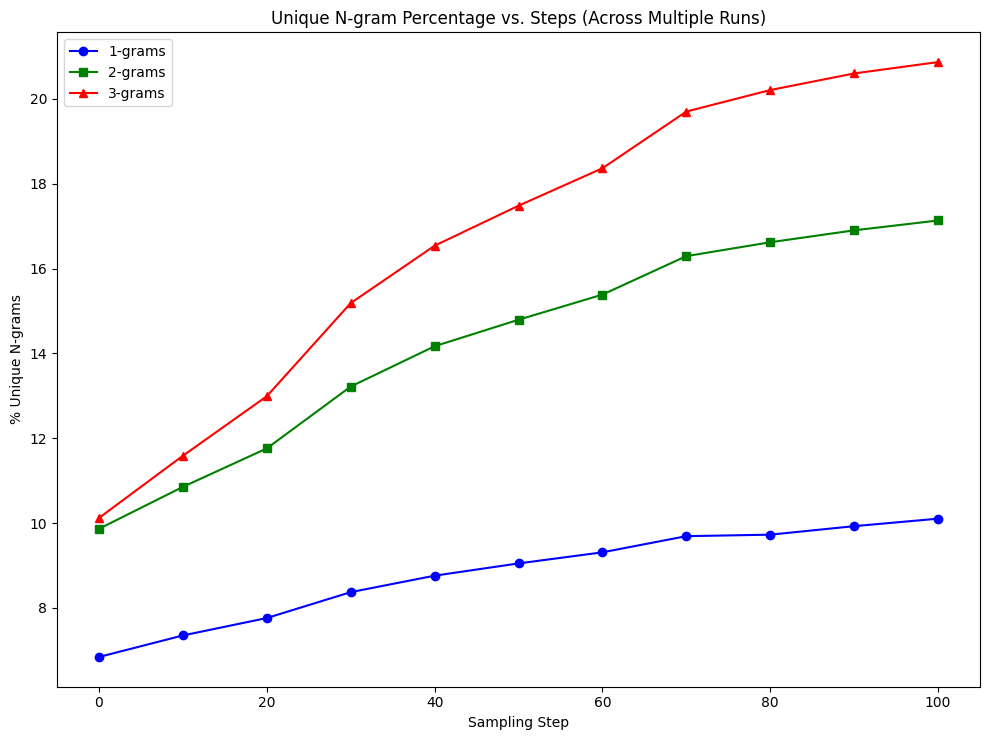


✅ Unique n-gram analysis complete! Results saved to unique_ngram_percentages.csv and unique_ngrams_vs_steps.png


In [38]:

import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForMaskedLM
import os
from collections import Counter

# Number of runs for each sentence
NUM_RUNS = 10

# Load model/tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")
model.eval()

# Load sentences
df = pd.read_csv('masked_lm1b_sentences.csv', header=None)
sentences = df[0].tolist()[:20]

# Parameters
n_steps = 101
save_every = 10  # Save every N steps
use_dmala = False
alpha = 0.15 if use_dmala else 0.1
N = tokenizer.vocab_size

# Function to get n-grams from text
def get_ngrams(text, n):
    tokens = text.split()
    return [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

# Initialize dictionaries to store n-grams for each step
step_to_all_1grams = {}
step_to_all_2grams = {}
step_to_all_3grams = {}

# Create output dir
os.makedirs("step_outputs", exist_ok=True)

# Process each sentence multiple times
for sentence_idx, sentence in enumerate(sentences):
    #print(f"\nProcessing sentence {sentence_idx+1}/{len(sentences)}")
    
    input_ids = tokenizer.encode(sentence, return_tensors='pt')
    mask_positions = [i for i, token in enumerate(input_ids[0]) if token == tokenizer.mask_token_id]
    m = len(mask_positions)

    if m == 0:
        print("No mask tokens found. Skipping.")
        continue
    
    for run in range(NUM_RUNS):
        #print(f"  Run {run+1}/{NUM_RUNS}")
        
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits

        logits_masked = [logits[0, pos, :] for pos in mask_positions]
        theta = [torch.argmax(logits_masked[i]).item() for i in range(m)]

        def compute_U(theta, logits_masked):
            log_probs = sum(torch.log_softmax(logits_masked[i], dim=0)[theta[i]] for i in range(m))
            return log_probs.item()

        def compute_proposal(i, theta, logits_masked, alpha):
            k = theta[i]
            scores = torch.full((N,), float('-inf'))
            scores[k] = 0
            mask = torch.ones(N, dtype=bool)
            mask[k] = False
            scores[mask] = 0.5 * (logits_masked[i][mask] - logits_masked[i][k]) - 1 / alpha
            return torch.softmax(scores, dim=0)

        for step in range(n_steps):
            theta_prime = []
            log_q_forward = 0
            for i in range(m):
                probs = compute_proposal(i, theta, logits_masked, alpha)
                k_prime = torch.multinomial(probs, 1).item()
                theta_prime.append(k_prime)
                log_q_forward += torch.log(probs[k_prime] + 1e-10).item()

            U_theta = compute_U(theta, logits_masked)
            U_theta_prime = compute_U(theta_prime, logits_masked)

            if use_dmala:
                log_q_backward = 0
                for i in range(m):
                    probs_back = compute_proposal(i, theta_prime, logits_masked, alpha)
                    log_q_backward += torch.log(probs_back[theta[i]] + 1e-10).item()
                log_accept = U_theta_prime - U_theta + log_q_backward - log_q_forward
                accept_prob = min(1, np.exp(log_accept))
                if np.random.rand() < accept_prob:
                    theta = theta_prime
            else:
                accept_prob = 1.0
                theta = theta_prime

            # Save output for this step if it's a save step
            if step % save_every == 0:
                tokens = input_ids[0].tolist()
                for pos, word_idx in zip(mask_positions, theta):
                    tokens[pos] = word_idx
                decoded = tokenizer.decode(tokens, skip_special_tokens=True)
                
                # Store n-grams for this step
                if step not in step_to_all_1grams:
                    step_to_all_1grams[step] = []
                    step_to_all_2grams[step] = []
                    step_to_all_3grams[step] = []
                
                step_to_all_1grams[step].extend(get_ngrams(decoded, 1))
                step_to_all_2grams[step].extend(get_ngrams(decoded, 2))
                step_to_all_3grams[step].extend(get_ngrams(decoded, 3))

# Calculate unique n-gram percentages for each step
steps = sorted(step_to_all_1grams.keys())
unique_1gram_pct = []
unique_2gram_pct = []
unique_3gram_pct = []

for step in steps:
    # 1-grams
    total_1grams = len(step_to_all_1grams[step])
    unique_1grams = len(set(step_to_all_1grams[step]))
    unique_1gram_pct.append(100 * unique_1grams / total_1grams if total_1grams > 0 else 0)
    
    # 2-grams
    total_2grams = len(step_to_all_2grams[step])
    unique_2grams = len(set(step_to_all_2grams[step]))
    unique_2gram_pct.append(100 * unique_2grams / total_2grams if total_2grams > 0 else 0)
    
    # 3-grams
    total_3grams = len(step_to_all_3grams[step])
    unique_3grams = len(set(step_to_all_3grams[step]))
    unique_3gram_pct.append(100 * unique_3grams / total_3grams if total_3grams > 0 else 0)

# Save results to CSV
results_df = pd.DataFrame({
    'Step': steps,
    'Unique_1gram_Percentage': unique_1gram_pct,
    'Unique_2gram_Percentage': unique_2gram_pct,
    'Unique_3gram_Percentage': unique_3gram_pct
})
results_df.to_csv('unique_ngram_percentages.csv', index=False)

# Create the plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7.5))

plt.plot(steps, unique_1gram_pct, marker='o', label='1-grams', color='blue')
plt.plot(steps, unique_2gram_pct, marker='s', label='2-grams', color='green')
plt.plot(steps, unique_3gram_pct, marker='^', label='3-grams', color='red')
plt.title("Unique N-gram Percentage vs. Steps (Across Multiple Runs)")
plt.xlabel("Sampling Step")
plt.ylabel("% Unique N-grams")
plt.legend()
plt.tight_layout()
plt.savefig("unique_ngrams_vs_steps.png")  # Save plot as PNG
plt.show()

print("\n✅ Unique n-gram analysis complete! Results saved to unique_ngram_percentages.csv and unique_ngrams_vs_steps.png")

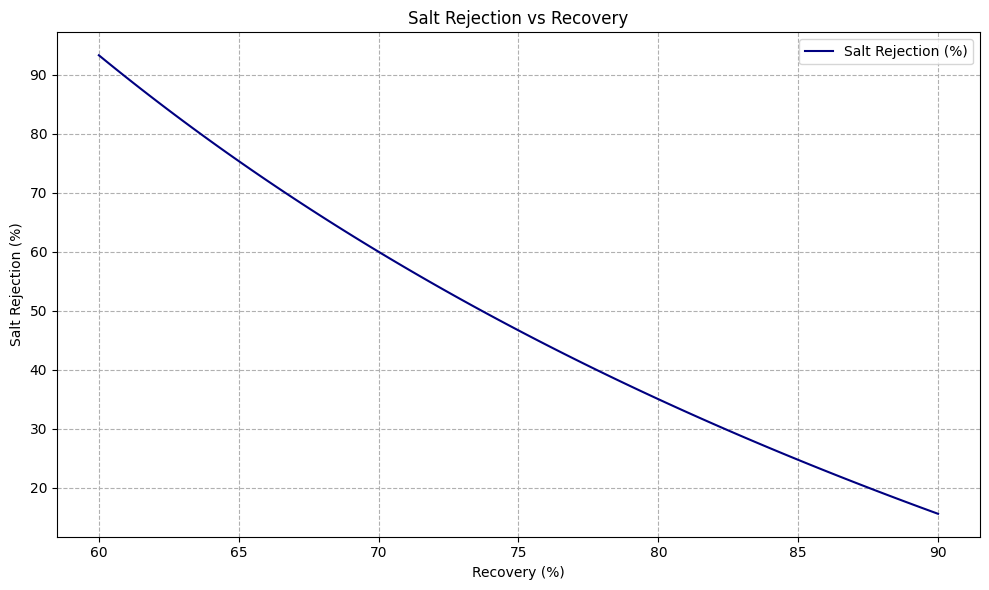

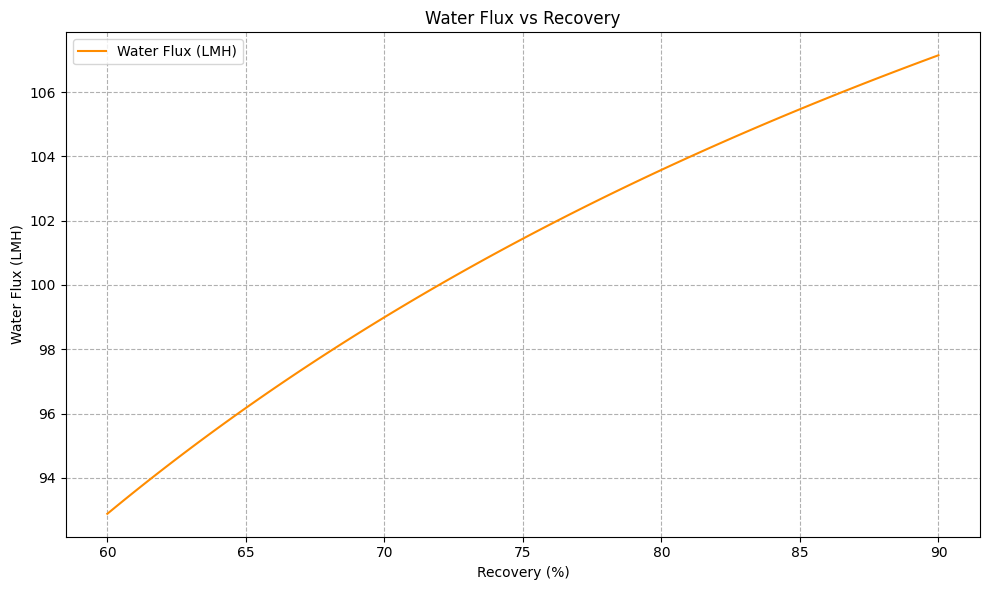

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Given parameters
Cf = 10.0  # g/L
Cb = 24.0  # g/L
A = 2.2    # LMH/bar
deltap = 50.0  # bar
# Molar mass of NaCl 
M_NaCl = 58.44  # g/mol

def osmotic_pressure(c_gL):
    c_molL = c_gL / M_NaCl
    return 0.08314 * 293 * 2 * c_molL  # Van’t Hoff

r = np.linspace(0.6, 0.9, 100)

# Mass balance and salt rejection
Cp = (Cf - (1 - r) * Cb) / r
rej = 1 - Cp / Cf

# Osmotic pressures
pif = osmotic_pressure(Cf)
pip = osmotic_pressure(Cp)
deltapi = pif - pip

# Water flux
J = A * (deltap - deltapi)

plt.figure(figsize=(10, 6))
plt.plot(r*100, rej*100, label='Salt Rejection (%)', color='navy')
plt.xlabel('Recovery (%)')
plt.ylabel('Salt Rejection (%)')
plt.title('Salt Rejection vs Recovery')
plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(r*100, J, label='Water Flux (LMH)', color='darkorange')
plt.xlabel('Recovery (%)')
plt.ylabel('Water Flux (LMH)')
plt.title('Water Flux vs Recovery')
plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()